In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Apr 25 04:39:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
from IPython.display import clear_output
import os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
from PIL import Image
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

### Data Processing

In [ ]:
ROOT_PATH = "/content/drive/MyDrive/Plant_Diseases/"
class_names = sorted(os.listdir(ROOT_PATH+'train/'))
print(class_names)

['Corn_Blight', 'Corn_Common_Rust', 'Corn_Gray_Spot', 'Corn_Healthy', 'Potato_Blight', 'Potato_Healthy', 'Rice_Blight', 'Rice_Brown_Spot', 'Rice_Leaf_Smut']


(525, 395)


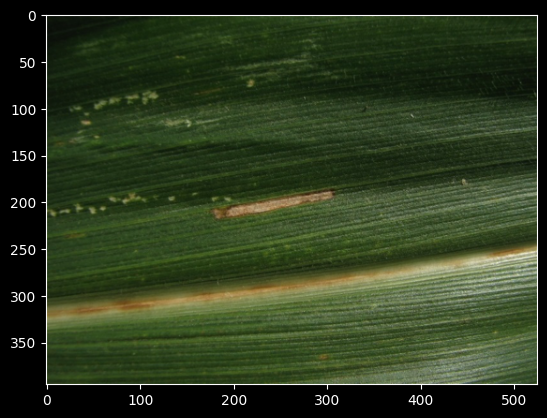

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
filenames = os.listdir(ROOT_PATH+'train/Corn_Gray_Spot')
sample = random.choice(filenames)
image = load_img(ROOT_PATH+'train/Corn_Gray_Spot/'+sample)
plt.style.use("dark_background")
plt.imshow(image)
print(image.size)

In [ ]:
def show_random_images_from(glob_path, seed):
    if seed:
        random.seed(seed)
    r = random.sample(glob(glob_path), 8)
    plt.figure(figsize=(10,6))
    for i, k in enumerate(r):
        plt.subplot(241 + i)
        plt.imshow(Image.open(k))
        plt.axis('off')

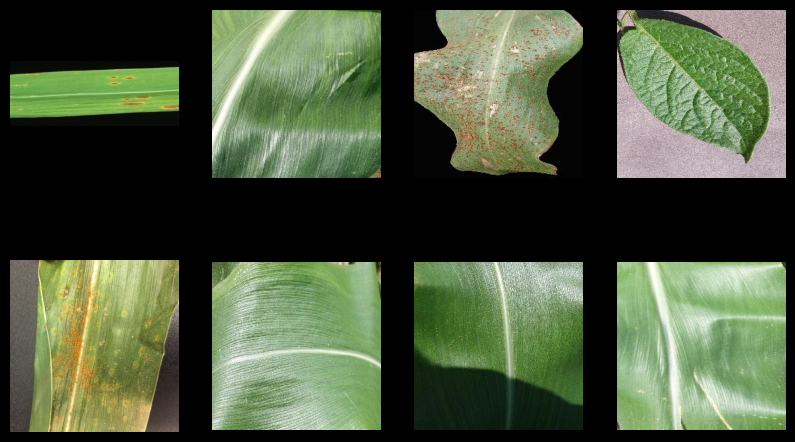

In [ ]:
show_random_images_from(ROOT_PATH+"*/*/*", seed=420)

### Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    channel_shift_range=0.1,
    brightness_range=[0.8, 1.2],
)


train_generator = datagen.flow_from_directory(
    ROOT_PATH+'train', 
    target_size=(150, 150),
    batch_size=8,
	class_mode='categorical')

test_generator = datagen.flow_from_directory(
    ROOT_PATH+'test',
    target_size=(150, 150),
    batch_size=8,
	class_mode='categorical')

Found 603 images belonging to 9 classes.
Found 123 images belonging to 9 classes.


### Model Building

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(len(class_names), activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 175232)            0         
                                                                 
 dense_1 (Dense)             (None, 9)                 1577097   
                                                                 
Total params: 1,577,993
Trainable params: 1,577,993
Non-trainable params: 0
_________________________________________________________________


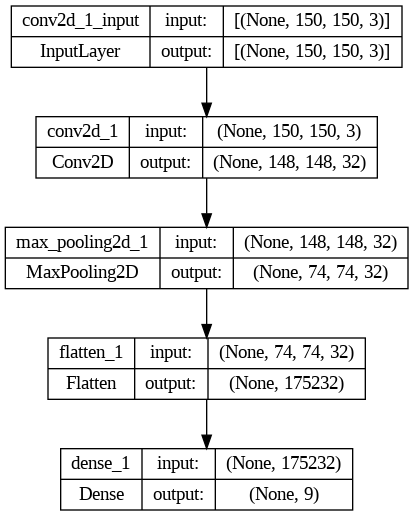

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_delta=0.0001)

history = model.fit(train_generator,
                    epochs=10,
                    validation_data=test_generator,
                    batch_size=8,
                    callbacks=[earlystop, reduce_lr])

Epoch 1/10
76/76 [==============================] - 399s 5s/step - loss: 4.1844 - accuracy: 0.3997 - val_loss: 1.3233 - val_accuracy: 0.5772 - lr: 0.0010
Epoch 2/10
76/76 [==============================] - 16s 210ms/step - loss: 0.9904 - accuracy: 0.6650 - val_loss: 1.1993 - val_accuracy: 0.6504 - lr: 0.0010
Epoch 3/10
76/76 [==============================] - 16s 209ms/step - loss: 0.8394 - accuracy: 0.6716 - val_loss: 1.0071 - val_accuracy: 0.7317 - lr: 0.0010
Epoch 4/10
76/76 [==============================] - 16s 212ms/step - loss: 0.7643 - accuracy: 0.7048 - val_loss: 1.0969 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 5/10
76/76 [==============================] - 16s 211ms/step - loss: 0.7431 - accuracy: 0.7164 - val_loss: 1.1023 - val_accuracy: 0.6748 - lr: 0.0010
Epoch 6/10
76/76 [==============================] - ETA: 0s - loss: 0.7804 - accuracy: 0.7081
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
76/76 [==============================] - 16s 205ms/

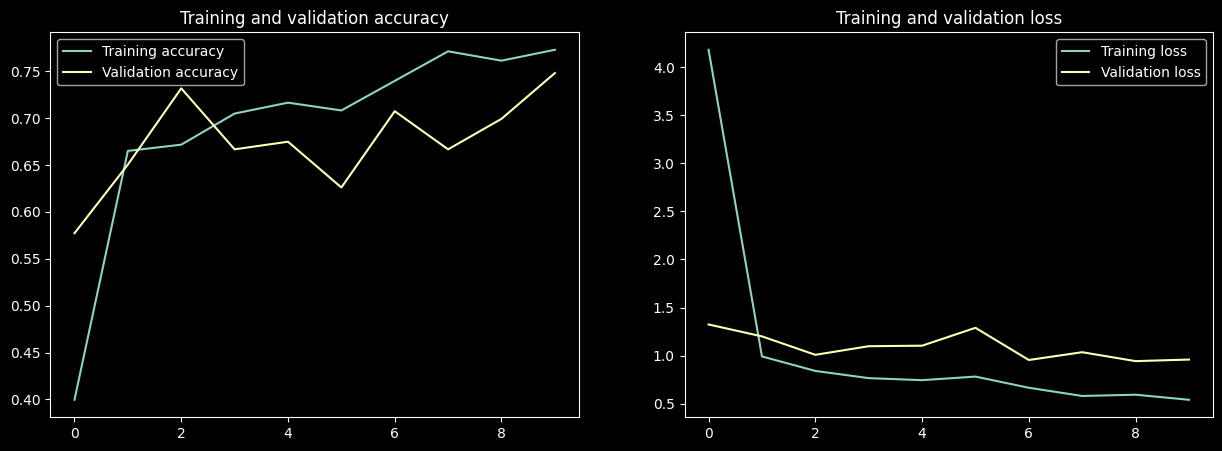

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)


ax1.plot(epochs, acc, label='Training accuracy')
ax1.plot(epochs, val_acc, label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.legend(loc=0)


ax2.plot(epochs, loss, label='Training loss')
ax2.plot(epochs, val_loss, label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.legend(loc=0)

In [ ]:
scores = model.evaluate(test_generator)
scores = model.evaluate(train_generator)

76/76 [==============================] - 14s 180ms/step - loss: 0.5532 - accuracy: 0.7711


### Model Testing

In [ ]:
import numpy as np

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 96ms/step


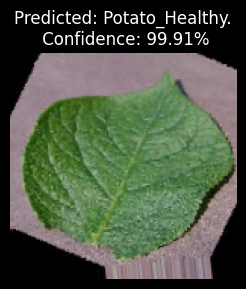

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in test_generator:
    for i in range(1):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model, images[i])
        
        plt.title(f"Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")
    break

In [ ]:
model.save('model.h5')

In [ ]:
model = tf.keras.models.load_model('model.h5')

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)